# House price prediction

This notebook is based on a popular [Kaggle](https://kaggle.com) competition for predicting house prices. The original dataset is [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

## Overview

We aim to train a model to predict house prices using the training dataset from Kaggle. This notebook follows a very standard process:

* Load training and test data
* Data exploration
* Feature selection
* Splitting the original training dataset into training and validation sets for cross-validation
* Fitting a random forest regression model

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Data exploration

In [3]:
training_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
print("Training data shape {}; test data shape {}".format(training_data.shape, test_data.shape))
print("Training data has {} unique data types".format(training_data.dtypes.unique()))

Training data shape (1460, 81); test data shape (1459, 80)
Training data has [dtype('int64') dtype('O') dtype('float64')] unique data types


In [4]:
training_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


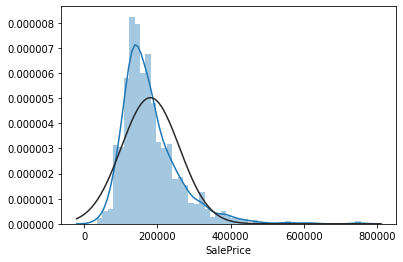

In [25]:
sns.distplot(training_data['SalePrice'], fit = norm)

# Data cleaning

In [19]:
print("Training data top columns with missing values:")
print(training_data.isnull().sum().sort_values(ascending=False).head(20))
print("Training data top columns with missing values:")
print(test_data.isnull().sum().sort_values(ascending=False).head(35))

Training data top columns with missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64
Training data top columns with missing values:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBat

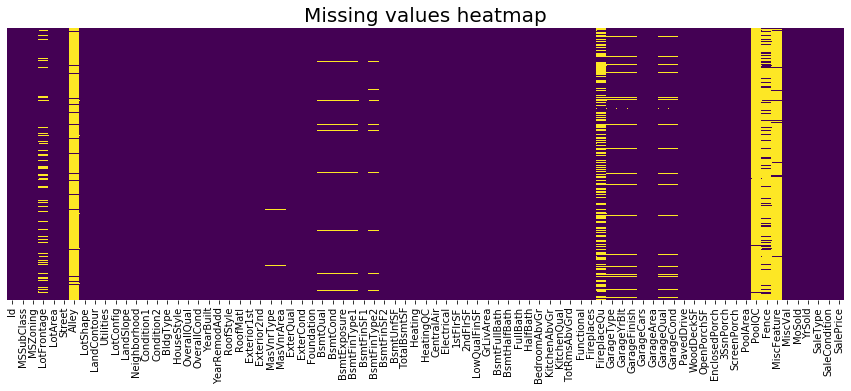

In [18]:
plt.figure(figsize=(15,5))
plt.title("Missing values heatmap", fontsize=20)
sns.heatmap(training_data.isnull(), yticklabels=0, cbar=False, cmap="viridis")

# Feature selection

In [28]:
y = training_data.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

X = training_data[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Model training with cross-validation

In [29]:
rf_model = RandomForestRegressor(random_state=1, n_estimators=10)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

Validation MAE for Random Forest Model: 22,762


# Model training on full dataset

In [30]:
# Train model on full dataset
rf_model_on_full_data = RandomForestRegressor(random_state=1, n_estimators=10)
rf_model_on_full_data.fit(X, y)

# Validate full model against validation set
rf_val_predictions = rf_model_on_full_data.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE trained on full dataset: {:,.0f}".format(rf_val_mae))

Validation MAE trained on full dataset: 8,809


# Model testing

In [36]:
test_X = test_data[features]
test_predictions = rf_model_on_full_data.predict(test_X)

#output = pd.DataFrame({'Id': test_data.Id, 'SalePrice': test_predictions})